In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuration
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
n_classes = 4  # Adjust based on your dataset

In [27]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names


Found 490 files belonging to 4 classes.


In [28]:
# Dataset partitions
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [29]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [30]:
# Preprocessing
#resize_and_rescale = tf.keras.Sequential([
#    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#    layers.experimental.preprocessing.Rescaling(1./255),
#])

In [31]:
# Prefetch and cache datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
# Apply data augmentation to training set
#train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
# Load pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
)

In [34]:
# Freeze the base model
base_model.trainable = False

In [39]:
# Build new model
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Build model
model.build((None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [42]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
12/12 [==============================] - 36s 2s/step - loss: 1.8279 - accuracy: 0.4062 - val_loss: 0.7061 - val_accuracy: 0.6875
Epoch 2/50
12/12 [==============================] - 27s 2s/step - loss: 0.8715 - accuracy: 0.6458 - val_loss: 0.4541 - val_accuracy: 0.8750
Epoch 3/50
12/12 [==============================] - 29s 2s/step - loss: 0.6666 - accuracy: 0.7188 - val_loss: 0.3910 - val_accuracy: 0.8750
Epoch 4/50
12/12 [==============================] - 28s 2s/step - loss: 0.5690 - accuracy: 0.7708 - val_loss: 0.1590 - val_accuracy: 0.9688
Epoch 5/50
12/12 [==============================] - 28s 2s/step - loss: 0.4962 - accuracy: 0.8073 - val_loss: 0.1519 - val_accuracy: 0.9688
Epoch 6/50
12/12 [==============================] - 29s 2s/step - loss: 0.4309 - accuracy: 0.8464 - val_loss: 0.2290 - val_accuracy: 0.9375
Epoch 7/50
12/12 [==============================] - 28s 2s/step - loss: 0.4255 - accuracy: 0.8359 - val_loss: 0.2854 - val_accuracy: 0.8750
Epoch 8/50
12/12 [==

In [43]:
# Evaluate model
scores = model.evaluate(test_ds)
print(f"Test loss: {scores[0]}")
print(f"Test accuracy: {scores[1]}")

3/3 [==============================] - 9s 3s/step - loss: 0.1665 - accuracy: 0.9583
Test loss: 0.16645215451717377
Test accuracy: 0.9583333134651184


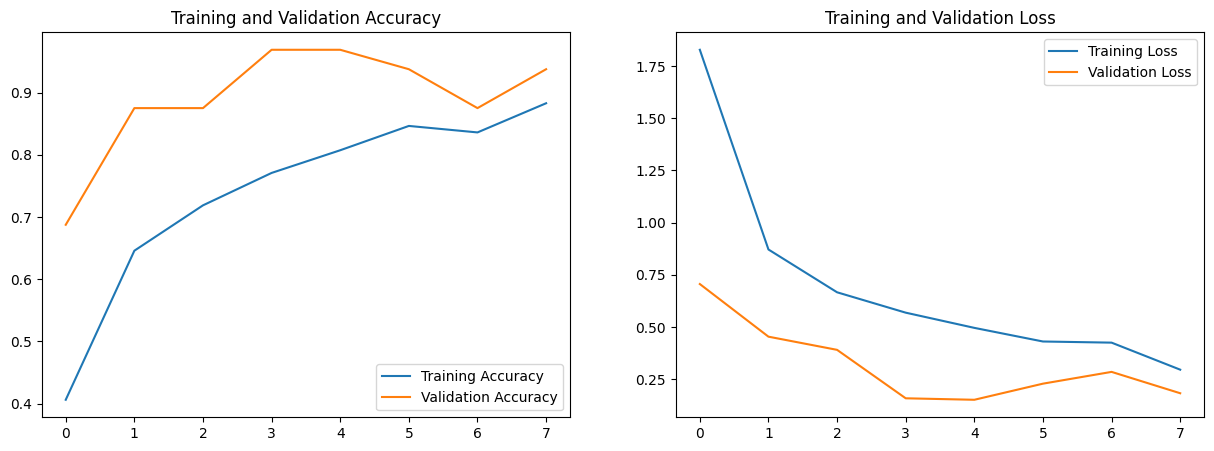

In [45]:
# Adjust the plotting to use the length of acc and val_acc
plt.figure(figsize=(15, 5))

# Training accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')  # Use len(acc)
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')  # Use len(val_acc)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training loss
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')  # Use len(loss)
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')  # Use len(val_loss)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [47]:
# Save model
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")
model.save("../trucks_v2.h5")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [48]:
# Predict function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [2]:
# Visualize predictions
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

NameError: name 'plt' is not defined